In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
print("Chargement du dataset...")
df = pd.read_csv('fraudTrain_balanced_smote.csv')

print(f"Shape du dataset : {df.shape}")
print(f"\nDistribution des classes :")
print(df['is_fraud'].value_counts())
print(f"\nColonnes : {df.columns.tolist()}")

Chargement du dataset...
Shape du dataset : (70000, 11)

Distribution des classes :
is_fraud
0    50000
1    20000
Name: count, dtype: int64

Colonnes : ['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [3]:
# ÉTAPE 2 : RÉSEAU DE NEURONES DQN
# =====================================================
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_sizes=[64, 32]):
        super(DQN, self).__init__()

        layers = []
        input_size = state_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_size = hidden_size

        layers.append(nn.Linear(input_size, action_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
# ÉTAPE 3 : REPLAY BUFFER
# =====================================================
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)

In [5]:
# ÉTAPE 4 : AGENT DQN
# =====================================================
class DQNAgent:
    def __init__(self, state_size, action_size=2, lr=0.001, gamma=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Utilisation du device : {self.device}")

        self.q_network = DQN(state_size, action_size).to(self.device)
        self.target_network = DQN(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        self.memory = ReplayBuffer(capacity=5000)

        self.losses = []
        self.rewards_history = []

    def select_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def train_step(self, batch_size=64):
        if len(self.memory) < batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.criterion(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        self.losses.append(loss.item())

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [6]:
# ÉTAPE 5 : ENVIRONNEMENT
# =====================================================
class FraudDetectionEnv:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.current_idx = 0
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)

    def reset(self):
        self.current_idx = 0
        return self.X_scaled[self.current_idx]

    def step(self, action):
        true_label = self.y.iloc[self.current_idx]
        state = self.X_scaled[self.current_idx]

        if action == true_label:
            reward = 10.0 if true_label == 1 else 1.0
        else:
            reward = -5.0 if true_label == 1 else -1.0

        self.current_idx += 1
        done = self.current_idx >= len(self.X)

        next_state = self.X_scaled[self.current_idx] if not done else state

        return next_state, reward, done

    def get_state_size(self):
        return self.X_scaled.shape[1]

In [7]:
# ÉTAPE 6 : PRÉPARATION DES DONNÉES
# =====================================================
print("\n" + "="*60)
print("PRÉPARATION DES DONNÉES")
print("="*60)

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set : {X_train.shape}")
print(f"Test set  : {X_test.shape}")
print(f"\nDistribution train :")
print(y_train.value_counts())
print(f"\nDistribution test :")
print(y_test.value_counts())


PRÉPARATION DES DONNÉES

Train set : (56000, 10)
Test set  : (14000, 10)

Distribution train :
is_fraud
0    40000
1    16000
Name: count, dtype: int64

Distribution test :
is_fraud
0    10000
1     4000
Name: count, dtype: int64


In [8]:
# ÉTAPE 7 : ENTRAÎNEMENT DU DQN
# =====================================================
print("\n" + "="*60)
print("DÉBUT DE L'ENTRAÎNEMENT DQN")
print("="*60)

env_train = FraudDetectionEnv(X_train, y_train)
state_size = env_train.get_state_size()

agent = DQNAgent(state_size=state_size, lr=0.001, gamma=0.95)

episodes = 10
batch_size = 128
episode_rewards = []

for episode in range(episodes):
    print(f"Episode {episode+1}/{episodes}")
    state = env_train.reset()
    total_reward = 0
    steps = 0

    while True:
        action = agent.select_action(state, training=True)
        next_state, reward, done = env_train.step(action)

        agent.memory.push(state, action, reward, next_state, done)

        loss = agent.train_step(batch_size)

        state = next_state
        total_reward += reward
        steps += 1

        if done:
            break

    agent.decay_epsilon()

    if episode % 5 == 0:
        agent.update_target_network()

    episode_rewards.append(total_reward)

    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Episode {episode+1}/{episodes} | "
              f"Reward: {total_reward:.2f} | "
              f"Avg Reward (10 ep): {avg_reward:.2f} | "
              f"Epsilon: {agent.epsilon:.4f}")

print("\n" + "="*60)
print("ENTRAÎNEMENT TERMINÉ ✓")
print("="*60)


DÉBUT DE L'ENTRAÎNEMENT DQN
Utilisation du device : cuda
Episode 1/10
Episode 2/10
Episode 3/10
Episode 4/10
Episode 5/10
Episode 6/10
Episode 7/10
Episode 8/10
Episode 9/10
Episode 10/10
Episode 10/10 | Reward: 43234.00 | Avg Reward (10 ep): 42485.10 | Epsilon: 0.9511

ENTRAÎNEMENT TERMINÉ ✓


In [9]:
# ÉTAPE 8 : ÉVALUATION
# =====================================================
print("\n" + "="*60)
print("ÉVALUATION SUR LE TEST SET")
print("="*60)

env_test = FraudDetectionEnv(X_test, y_test)
state = env_test.reset()

predictions = []
true_labels = []

for i in range(len(X_test)):
    action = agent.select_action(state, training=False)
    predictions.append(action)
    true_labels.append(y_test.iloc[i])

    state, _, done = env_test.step(action)

    if done:
        break

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Métriques
print("\n📊 CONFUSION MATRIX:")
cm = confusion_matrix(true_labels, predictions)
print(cm)
print(f"\n{'':>15} Predicted")
print(f"{'':>15} Non-Fraud  Fraud")
print(f"Actual Non-Fraud  {cm[0][0]:>7}  {cm[0][1]:>7}")
print(f"       Fraud      {cm[1][0]:>7}  {cm[1][1]:>7}")

print("\n📈 CLASSIFICATION REPORT:")
print(classification_report(true_labels, predictions,
                            target_names=['Non-Fraude', 'Fraude']))

# Métriques détaillées
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0




ÉVALUATION SUR LE TEST SET

📊 CONFUSION MATRIX:
[[6830 3170]
 [ 434 3566]]

                Predicted
                Non-Fraud  Fraud
Actual Non-Fraud     6830     3170
       Fraud          434     3566

📈 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Non-Fraude       0.94      0.68      0.79     10000
      Fraude       0.53      0.89      0.66      4000

    accuracy                           0.74     14000
   macro avg       0.73      0.79      0.73     14000
weighted avg       0.82      0.74      0.75     14000


🎯 MÉTRIQUES FINALES:
Accuracy:       0.7426 (74.26%)
Precision:      0.5294 (52.94%)
Recall:         0.8915 (89.15%)
F1-Score:       0.6643



📊 Génération des graphiques...


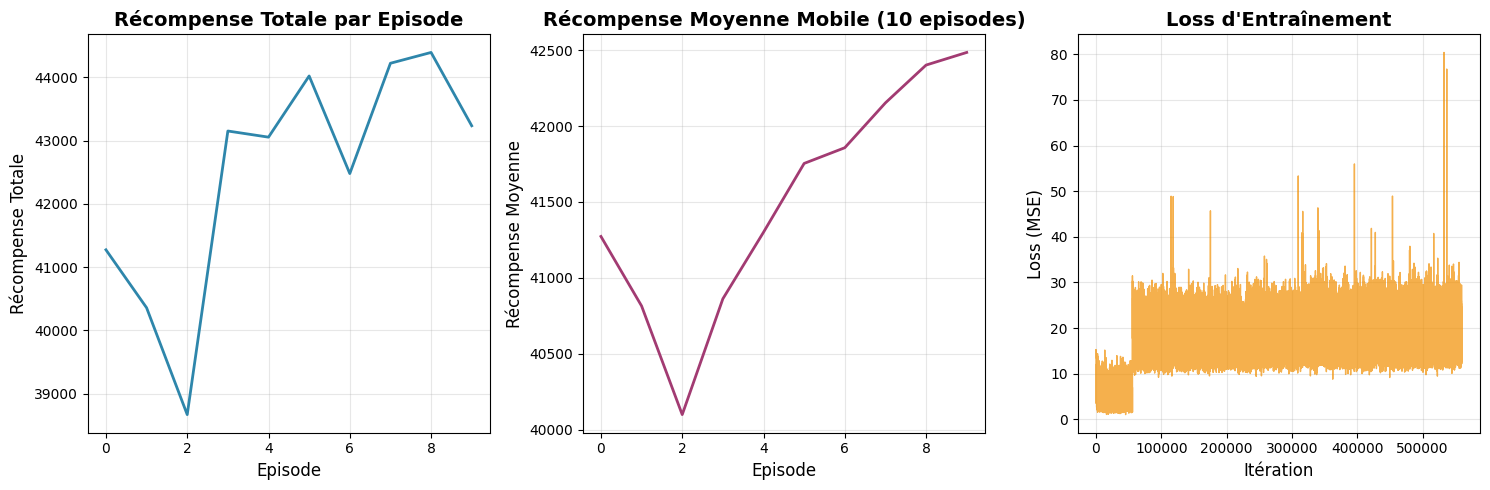

✓ Graphiques sauvegardés: 'dqn_training_results.png'

💾 Sauvegarde du modèle...
✓ Modèle sauvegardé: 'dqn_fraud_detection_model.pth'

✅ PROCESSUS TERMINÉ AVEC SUCCÈS


In [10]:
print("\n📊 Génération des graphiques...")

plt.figure(figsize=(15, 5))

# Graphique 1: Récompenses par épisode
plt.subplot(1, 3, 1)
plt.plot(episode_rewards, linewidth=2, color='#2E86AB')
plt.title('Récompense Totale par Episode', fontsize=14, fontweight='bold')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Récompense Totale', fontsize=12)
plt.grid(True, alpha=0.3)

# Graphique 2: Moyenne mobile des récompenses
plt.subplot(1, 3, 2)
window = 10
moving_avg = [np.mean(episode_rewards[max(0, i-window):i+1]) for i in range(len(episode_rewards))]
plt.plot(moving_avg, linewidth=2, color='#A23B72')
plt.title(f'Récompense Moyenne Mobile ({window} episodes)', fontsize=14, fontweight='bold')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Récompense Moyenne', fontsize=12)
plt.grid(True, alpha=0.3)

# Graphique 3: Loss
plt.subplot(1, 3, 3)
plt.plot(agent.losses, linewidth=1, alpha=0.7, color='#F18F01')
plt.title('Loss d\'Entraînement', fontsize=14, fontweight='bold')
plt.xlabel('Itération', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dqn_training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphiques sauvegardés: 'dqn_training_results.png'")

# =====================================================
# ÉTAPE 10 : SAUVEGARDE DU MODÈLE
# =====================================================
print("\n💾 Sauvegarde du modèle...")
torch.save({
    'model_state_dict': agent.q_network.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'episode_rewards': episode_rewards,
    'losses': agent.losses
}, 'dqn_fraud_detection_model.pth')

print("✓ Modèle sauvegardé: 'dqn_fraud_detection_model.pth'")

print("\n" + "="*60)
print("✅ PROCESSUS TERMINÉ AVEC SUCCÈS")
print("="*60)